## Predict features' categories and evaluate performance (cannonball)

In [1]:
import os
import openai
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay
import sklearn
from sklearn.metrics import mean_squared_error,mean_absolute_error,f1_score,classification_report
import numpy as np
import matplotlib.pyplot as plt
import random
openai.api_key = os.getenv("OPENAI_API_KEY")

## Get predictions

In [2]:
df=pd.read_csv("../../input_data/complete_file.csv")


preprompt="Consider this situation and answer the question that follows:\nSituation:"

df=df.assign(statement=preprompt+df.scenario+"\nQuestion: ")

df=df.loc[df.study=='cannonball',:].reset_index(drop=True)

In [3]:
compr="Why are the kids not allowed to cannonball into the pool?"
f1a="Will the kids in the art tent get distracted? Answer with one of the following: definitely no, maybe no, maybe yes, definitely yes."
f1b="Will the art get ruined? Answer with one of the following: definitely no, maybe no, maybe yes, definitely yes."
f2="How much did that help someone else? Answer with one of the following: not at all, a little, a lot, or a whole lot ?"
f3="How much did the kid need to do that? Answer with one of the following: not at all, a little, a lot, or a whole lot?"
final_q="Taking all of this into account, was it OK or not OK for the kid to cannonball into the pool? Explain your answer."

In [4]:
df=df.assign(feat2_cat=np.where(df.feature2<=0.1,"1. not at all",
                                        np.where(df.feature2<=0.2,"2. a little",
                                        np.where(df.feature2<=0.3,"3. a lot","4. a whole lot"))))
df=df.assign(feat3_cat=np.where(df.feature3<=0.1,"1. not at all",
                                        np.where(df.feature3<=0.2,"2. a little",
                                        np.where(df.feature3<=0.3,"3. a lot","4. a whole lot"))))
df=df.assign(feat1_cat=np.where(df.feature1<=0.2,"1. definitely no",
                                        np.where(df.feature1<=0.4,"2. maybe no",
                                        np.where(df.feature1<=0.6,"3. maybe yes","4. definitely yes"))))

In [5]:
for i,d in df.iterrows():
    input_prompt=d['statement']+f2
    completion = openai.Completion.create(engine="text-davinci-002", prompt=input_prompt,temperature=0,max_tokens=60)
    df.loc[i,'first_response']=completion.choices[0].text
    
    input_2=d['statement']+"\nQuestion: "+f3+"\n"
    second_response = openai.Completion.create(engine="text-davinci-002", prompt=input_2,temperature=0,max_tokens=60)
    df.loc[i,'second_response']=second_response.choices[0].text
    if d['condition']=='noise':
        f1=f1a
    else:
        f1=f1b
    input_3=d['statement']+"\nQuestion: "+f1+"\n"
    third_response = openai.Completion.create(engine="text-davinci-002", prompt=input_3,temperature=0,max_tokens=60)
    df.loc[i,'third_response']=third_response.choices[0].text

    resp_final=df.loc[i,'third_response']

## Assign categories

In [6]:
df=df.assign(predf2=
    np.where(df.first_response.str.lower().str.contains('at all'),'1. not at all',
    np.where(df.first_response.str.lower().str.contains('a little'),'2. a little',
    np.where(df.first_response.str.lower().str.contains('a lot'),'3. a lot',
    np.where(df.first_response.str.lower().str.contains('a whole lot'),'4. a whole lot',"None")))))

df=df.assign(predf3=
    np.where(df.second_response.str.lower().str.contains('at all'),'1. not at all',
    np.where(df.second_response.str.lower().str.contains('a little'),'2. a little',
    np.where(df.second_response.str.lower().str.contains('a lot'),'3. a lot',
    np.where(df.second_response.str.lower().str.contains('a whole lot'),'4. a whole lot',"None")))))

df=df.assign(predf1=
    np.where(df.third_response.str.lower().str.contains('definitely no'),'1. definitely no',
    np.where(df.third_response.str.lower().str.contains('maybe no'),'2. maybe no',
    np.where(df.third_response.str.lower().str.contains('maybe yes'),'3. maybe yes',
    np.where(df.third_response.str.lower().str.contains('definitely yes'),'4. definitely yes',"None")))))

## numeric
df=df.assign(gpt_feature2=
    np.where(df.first_response.str.lower().str.contains('at all'),4,
    np.where(df.first_response.str.lower().str.contains('a little'),3,
    np.where(df.first_response.str.lower().str.contains('a lot'),2,
    np.where(df.first_response.str.lower().str.contains('a whole lot'),1,None)))))

df=df.assign(gpt_feature3=
    np.where(df.second_response.str.lower().str.contains('at all'),4,
    np.where(df.second_response.str.lower().str.contains('a little'),3,
    np.where(df.second_response.str.lower().str.contains('a lot'),2,
    np.where(df.second_response.str.lower().str.contains('a whole lot'),1,None)))))

df=df.assign(gpt_feature1=
    np.where(df.third_response.str.lower().str.contains('definitely no'),4,
    np.where(df.third_response.str.lower().str.contains('maybe no'),3,
    np.where(df.third_response.str.lower().str.contains('maybe yes'),2,
    np.where(df.third_response.str.lower().str.contains('definitely yes'),1,None)))))


## Assign random features

In [7]:
random.seed(0)

l = [random.randint(0,3) for i in range(df.shape[0])]

df=df.assign(feat2_rand=l)

df=df.assign(feat2_rands=
    np.where(df.feat2_rand==0,'1. not at all',
    np.where(df.feat2_rand==1,'2. a little',
    np.where(df.feat2_rand==2,'3. a lot',
    np.where(df.feat2_rand==3,'4. a whole lot',"None")))))

l = [random.randint(0,3) for i in range(df.shape[0])]

df=df.assign(feat3_rand=l)

df=df.assign(feat3_rands=
    np.where(df.feat3_rand==0,'1. not at all',
    np.where(df.feat3_rand==1,'2. a little',
    np.where(df.feat3_rand==2,'3. a lot',
    np.where(df.feat3_rand==3,'4. a whole lot',"None")))))

l = [random.randint(0,3) for i in range(df.shape[0])]

df=df.assign(feat1_rand=l)

df=df.assign(feat1_rands=
    np.where(df.feat1_rand==0,'1. definitely no',
    np.where(df.feat1_rand==1,'2. maybe no',
    np.where(df.feat1_rand==2,'3. maybe yes',
    np.where(df.feat1_rand==3,'4. definitely yes',"None")))))

## Evaluate

### Feature 2

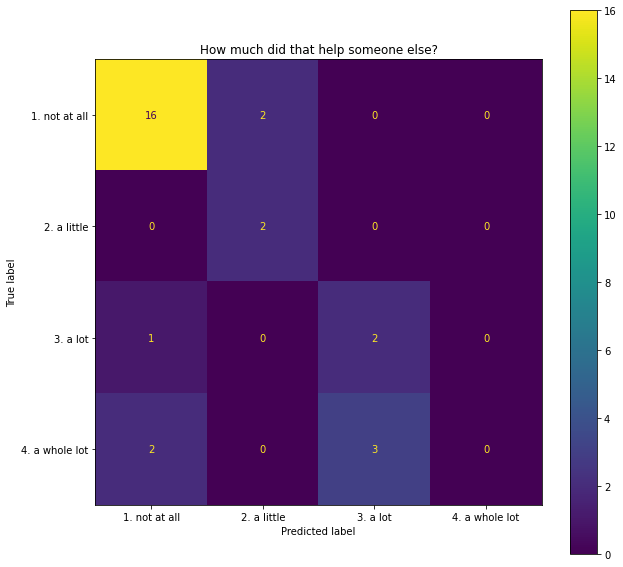

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(df.feat2_cat,df.predf2,ax=ax)
plt.title("How much did that help someone else?")
plt.show()

In [9]:
gen=classification_report(df.feat2_cat,df.predf2,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  65.72
Accuracy:  71.43


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [10]:
gen=classification_report(df.feat2_cat,df.feat2_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])
print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  25.70
Accuracy:  25.00


### Feature 3

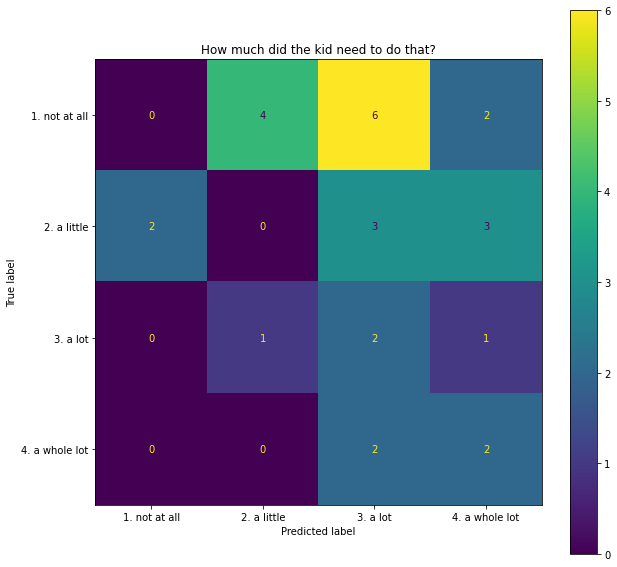

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(df.feat3_cat,df.predf3,ax=ax)
plt.title("How much did the kid need to do that?")
plt.show()

In [12]:
gen=classification_report(df.feat3_cat,df.predf3,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  8.12
Accuracy:  14.29


In [13]:
gen=classification_report(df.feat3_cat,df.feat3_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  25.96
Accuracy:  25.00


### Feature 1

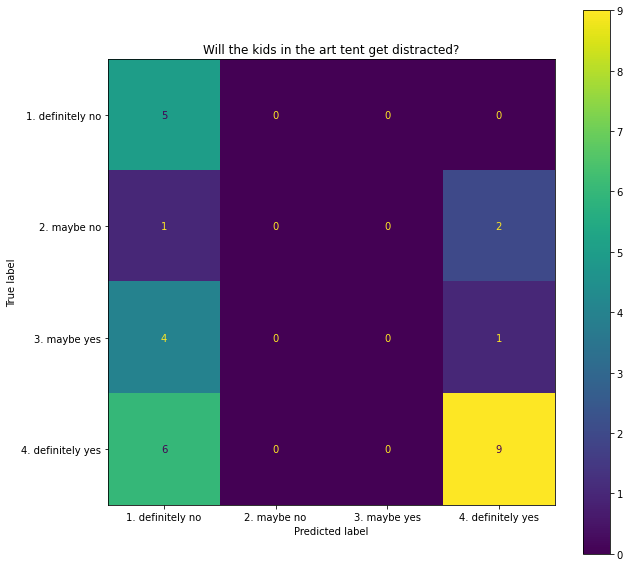

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(df.feat1_cat,df.predf1,ax=ax)
plt.title("Will the kids in the art tent get distracted?")
plt.show()

In [15]:
gen=classification_report(df.feat1_cat,df.predf1,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  44.22
Accuracy:  50.00


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [16]:
gen=classification_report(df.feat1_cat,df.feat1_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  35.36
Accuracy:  32.14


In [17]:
df.to_csv("../../outputs/analysis/features/cannonball_featues.csv",index=False)

In [ ]:

#cannonball=df.loc[:,['context', 'condition', 'study', 'human.response', 'feature1','gpt_feature1',
#       'feature2', 'gpt_feature2','feature3', 'gpt_feature3','feature1b', 'feature1c', 'prompt',
#       'prompt_short', 'prompt_long']]


#cannonball.to_csv("./cannonball_features_categorical.csv",index=False)